# Variational Autoencoder

In [1]:
# Author: Vivian Wong
# Modified from Code by Sherlock Liao available at https://github.com/L1aoXingyu/pytorch-beginner?files=1

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [2]:
def load_meltpool_dataset():
    root = './data/meltpool/Meltpool_Camera_(partial)'
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(70),
        transforms.Resize(28),
        transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset, dataloader

def load_MNIST_dataset():
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = MNIST('./data', transform=transform, download=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader

In [3]:
# autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z, self.decode(z), mu, logvar

In [15]:
if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')
    
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 30
learning_rate = 1e-3

dataset, dataloader = load_meltpool_dataset()
# dataset, dataloader = load_MNIST_dataset()

using device: cpu


In [5]:
def plot2D_with_labels(XY, labels, num_labels=9):
    if type(XY)==torch.Tensor:
        XY = XY.numpy()
    plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / num_labels)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)

In [6]:
def plot3D_with_labels(XYZ, labels, num_labels=9):
    if type(XYZ)==torch.Tensor:
        XYZ = XYZ.numpy()
    fig = plt.figure(2); ax = Axes3D(fig)
    X, Y, Z = XYZ[:, 0].numpy(), XYZ[:, 1].numpy(), XYZ[:, 2].numpy() # put encoded data to [x,y,z]
    digits = train_data.train_labels[:200].numpy()
    for x, y, z, s in zip(X, Y, Z, digits):
        c = cm.rainbow(int(255*s/num_labels)); ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
    plt.show()

In [7]:
def plot2D_with_thumbnails(XY, labels, thumbnails, num_labels = 9, cmap = None):
    def getThumbnail(path):
        return OffsetImage(plt.imread(path), zoom=0.5, cmap=cmap)

    if type(XY)==torch.Tensor:
        XY = XY.numpy()
#     plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(X, Y) 
    for x, y, s, path in zip(X, Y, labels, thumbnails):
        ab = AnnotationBbox(getThumbnail(path), (x, y), frameon=True)
        ax.add_artist(ab)
#         c = cm.rainbow(int(255 * s / num_labels))
#         plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#         plt.scatter(x, y, marker=path)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)
    
  

In [16]:
# train autoencoder
model = autoencoder().to(device)
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        _, recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.data / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_img/image_{}.png'.format(epoch))
        torch.save(model.state_dict(), './vae.pth')

Train Epoch: 0 [0/62609 (0%)]	Loss: 163.070709
Train Epoch: 0 [12800/62609 (20%)]	Loss: 7.589916
Train Epoch: 0 [25600/62609 (41%)]	Loss: 6.948514
Train Epoch: 0 [38400/62609 (61%)]	Loss: 5.673496
Train Epoch: 0 [51200/62609 (82%)]	Loss: 5.539942
====> Epoch: 0 Average loss: 8.8370
Train Epoch: 1 [0/62609 (0%)]	Loss: 5.158287
Train Epoch: 1 [12800/62609 (20%)]	Loss: 5.309936
Train Epoch: 1 [25600/62609 (41%)]	Loss: 4.633119
Train Epoch: 1 [38400/62609 (61%)]	Loss: 4.424184
Train Epoch: 1 [51200/62609 (82%)]	Loss: 4.837172
====> Epoch: 1 Average loss: 4.8327
Train Epoch: 2 [0/62609 (0%)]	Loss: 4.313977
Train Epoch: 2 [12800/62609 (20%)]	Loss: 4.490317
Train Epoch: 2 [25600/62609 (41%)]	Loss: 4.625626
Train Epoch: 2 [38400/62609 (61%)]	Loss: 4.420845
Train Epoch: 2 [51200/62609 (82%)]	Loss: 4.584363
====> Epoch: 2 Average loss: 4.5374
Train Epoch: 3 [0/62609 (0%)]	Loss: 4.479197
Train Epoch: 3 [12800/62609 (20%)]	Loss: 4.329752
Train Epoch: 3 [25600/62609 (41%)]	Loss: 4.419865
Train Epoc

====> Epoch: 28 Average loss: 4.0336
Train Epoch: 29 [0/62609 (0%)]	Loss: 4.055386
Train Epoch: 29 [12800/62609 (20%)]	Loss: 4.008765
Train Epoch: 29 [25600/62609 (41%)]	Loss: 3.804733
Train Epoch: 29 [38400/62609 (61%)]	Loss: 4.075323
Train Epoch: 29 [51200/62609 (82%)]	Loss: 3.757884
====> Epoch: 29 Average loss: 4.0292


In [17]:
torch.save(model.state_dict(), './vae.pth')

## View encoder output in 2D

In [122]:
# optional - load model state dict
model = autoencoder().to(device)
model.load_state_dict(torch.load('./vae.pth'))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

### Meltpool

In [22]:
num_viewed = 200
random_seed = 1
indices = list(range(len(dataset)))
np.random.seed(random_seed)
np.random.shuffle(indices)
view_indices = indices[:num_viewed]
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
view_data_layers = np.random.randint(1, size=num_viewed)

view_thumbnails = [dataset.imgs[i][0] for i in view_indices]
for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    view_data_layers[i] = int(dataset[view_indices[i]][1])
    
encoded_data, _, _, _ = model(view_data)
# # view encoder output in 2D
# plot2D_with_labels(encoded_data.data, view_data_layers, num_labels = 15)
# plot2D_with_thumbnails(encoded_data.data, view_data_layers, view_thumbnails, num_labels = 15, cmap = 'gray')

#### View encoder output using T-SNE

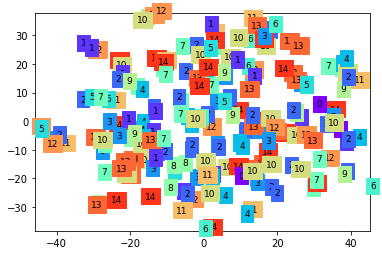

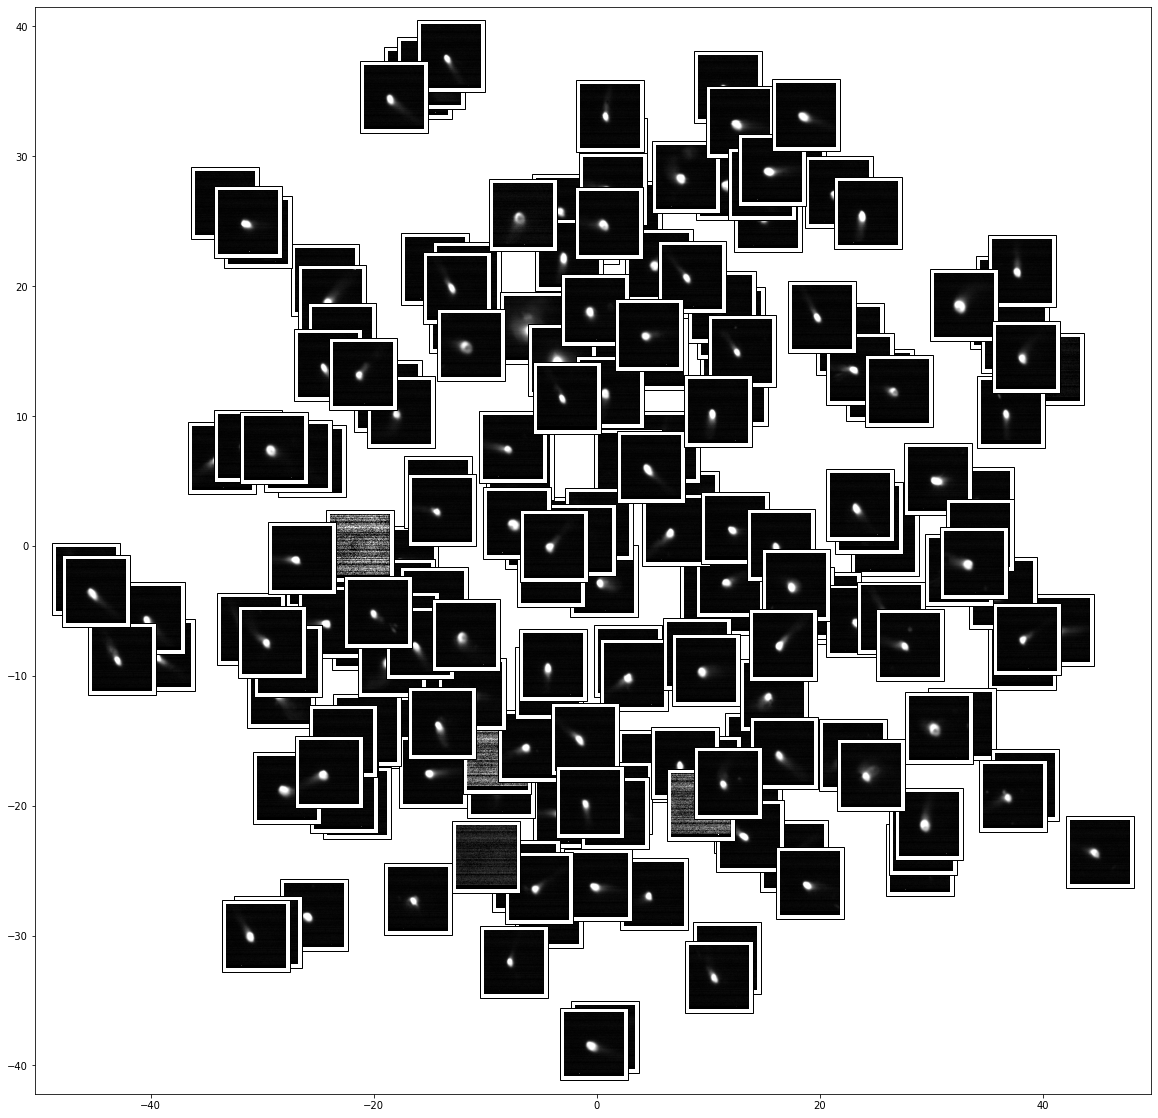

In [ ]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, view_data_layers, num_labels = 15)
plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15, cmap='gray')

plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15)

### MNIST

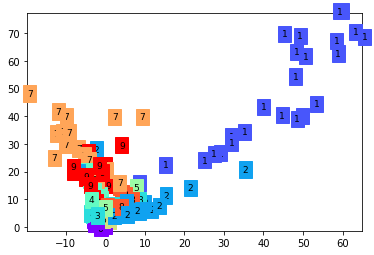

In [121]:
num_viewed = 200
view_indices = list(range(len(dataset)))
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
digits = np.random.randint(1, size=num_viewed)

for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    digits[i] = dataset[view_indices[i]][1]
    
encoded_data, _ = model(view_data)
plot2D_with_labels(encoded_data.data, digits)

# # alternate way to do the above
# view_data = dataset.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255. # flatten each image to vector then normalize so max is max 1. 
# encoded_data, _ = model(view_data)

# digits = dataset.targets[:200].numpy()
# # view encoder output in 2D
# plot2D_with_labels(encoded_data.data, digits)

#### View encoder output using T-SNE

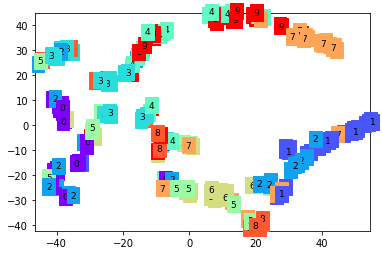

In [44]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, digits)